In [30]:
from keras.models import model_from_json
from s1p10_training_utils import gen_regressor_dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Load Model

In [2]:
MODEL_DIR = "./s1p10_model/"

# load json and create model
with open(MODEL_DIR + "s1p10_noLSTM_model_2019_05_29_16_20.json", 'r') as json_file:
    loaded_model_json = json_file.read()

model = model_from_json(loaded_model_json)

# load weights into new model
model.load_weights(MODEL_DIR + "s1p10_noLSTM_model_2019_05_29_16_20.h5")
print("Loaded model from disk")

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_in (InputLayer)        (None, 200, 200, 1)       0         
_________________________________________________________________
resnet8 (Model)              (None, 6272)              309088    
_________________________________________________________________
regressor (Model)            (None, 5)                 8369405   
Total params: 8,678,493
Trainable params: 8,369,405
Non-trainable params: 309,088
_________________________________________________________________


# Load Validation Dataset

In [5]:
gen_param = {'num_labels': 5, 
             'image_shape': (200, 200, 1), 
             'num_samples': None, 
             'data_root_dir': "/home/user/Bureau/Dataset/udacity/", 
             'flip_prob': 0.5}
X_val, y_val = gen_regressor_dataset("./s1p10_data/s1p10_CH2_002_output_validation.csv", **gen_param)

In [6]:
X_val.shape

(2026, 200, 200, 1)

In [7]:
y_val.shape

(2026, 5)

In [9]:
# Get test data
test_sample_X = X_val[:4, :, :, :]
test_sample_y = y_val[:4, :]

In [11]:
# Get model prediction
pred_y = model.predict(test_sample_X)

pred_y

array([[ 6.1549549e-04,  1.2898331e-03,  7.5835153e-05,  8.0024998e-04,
        -8.3582301e-04],
       [ 6.1549549e-04,  1.2898331e-03,  7.5835153e-05,  8.0024998e-04,
        -8.3582301e-04],
       [ 6.1549549e-04,  1.2898331e-03,  7.5835153e-05,  8.0024998e-04,
        -8.3582301e-04],
       [ 6.1549549e-04,  1.2898331e-03,  7.5835153e-05,  8.0024998e-04,
        -8.3582301e-04]], dtype=float32)

In [22]:
def steering_angle_to_next_pos(angle, arc_length=2.0):
    """
    Calculate next position in the body frame of the current image frame
        Input:
            angle (float): steering angle in radian
    """
    if np.absolute(angle) < 1e-5:
        next_y = 0
        next_x = arc_length
    else:
        R = arc_length / angle
        next_y = R * (1 - np.cos(angle))
        next_x = R * np.sin(angle)
    return np.array([next_x, next_y])
        

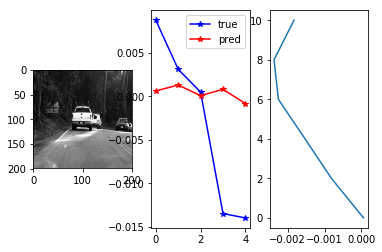

In [44]:
disp_idx = 2

# Calculate position along the whole sequence of prediction
pred_seq = pred_y[disp_idx, :]
way_pts = np.zeros((6, 2))
for i, angle in enumerate(pred_seq):
    next_pos = steering_angle_to_next_pos(angle)
    way_pts[i + 1, :] = way_pts[i, :] + next_pos 
# print(way_pts)

# smoothen waypts (just for display purpose)
way_pts_y = savgol_filter(way_pts[:, 1], 5, 3)

# Display
plt.subplot(131)
plt.imshow(test_sample_X[disp_idx, :, :, 0], cmap='gray')
plt.subplot(132)
plt.plot(test_sample_y[disp_idx, :], 'b-*', label='true')
plt.plot(pred_y[disp_idx, :], 'r-*', label='pred')
plt.legend()
plt.subplot(133)
plt.plot(-way_pts_y, way_pts[:, 0])
plt.show()

# TODO Generate driving video